# Comparison of ARIMA and LSTM for time series forecasting
## Air pollution dataset

The goal
 is to compare performance of traditional ARIMA models and Recurrent Neural Networks (LSTMs) for time series forecasting. This comparison is not straightforward due to the different nature of the methods, therefore we need to spend some time discussing the different approaches.  






In a time-series forecasting problem, we observe a time series $X_1,\dots, X_{t}$ and our goal is to forecast $h$ new time-steps $X_{t+1}, ..., X_{t+h}$. The number of time periods to forecast into the future, $h$, is referred to as the forecasting horizon.

Forecasting strategies vary depending on how we formulate the problem. We summarize some of the main approaches below.

**Forecasting strategies**

  1. **Recursive**

     The recursive forecasting strategy uses a single model pre-trained for one-step forecasting. At each time-step, we use the forecast from the previous time-step to compute a forecast for the current time-step.

  2. **Direct**

    In the direct approach, we forecast $X_{t+1}, ..., X_{t+h}$ directly using $X_{1},\dots,X_{t}$. This means that the forecasts do not depend on previous forecasts, only on the observed time series.
    
    This approach can be implemented in different ways:
    1. **Lag models**: Train $h$ models, one for every time period separately. Each model is trained with target being the time series shifted by the desired number of time periods into the future. For example, if the forecasting horizon was $h=3$, then we train 3 models: one for 1-step forecasts, one for 2-step forecasts and one for 3-step forecasts.  
    This approach is applicable to any ML/neural network model.

    2. **Multi-output**: Train a single multi-output model. This approach is applicable to neural networks.


  3. **Hybrid**

  Hybrid approaches are a combination of recursive and direct forecasting: for example, train one model for each time step but at each time-step, include all the previous forecasts in the model to improve the next forecast. 

**Measuring performance**

If we choose a particular strategy for forecasting and train a model accordingly, we can compute the model's forecasts $\hat X_{t+1}, \dots, \hat X_{t+h}$. Then given that we have also observed the true values $X_{t+1}, ..., X_{t+h}$, we can compute the forecasting error. This can be the mean-squared error (MSE) or the more robust and commonly used mean absolute percentage error (MAPE)
$$MAPE = \frac{1}{h}\sum_{j=1}^h\left|\frac{\hat X_{j} - X_j}{X_j}\right|.$$

**Reducing error variance**

To reduce the variance of the error estimator, we can create multiple sets of forecasts $\hat X_{t+1}, \dots, \hat X_{t+h}$ by using a different starting origin for each set of forecasts. Then to compute a final error estimate we average the forecasting errors across these. 

**Exogeneous variables**

In practice, in addition to the time series $X_t$, we often have additional observed time series $(Y_t, Z_t, \dots)$. This further complicates the forecasting strategies above. 

For example, the recursive strategy no longer becomes feasible unless we predict multi-variate outputs $(X_{t+1},Y_{t+1},Z_{t+1}, \dots)$. In this guide, we only focus on univariate forecasting. 
The direct forecasting strategies remain feasible.



# Experimental setup

In our comparison, we will consider three different forecasting scenarios:
1. **Short horizon scenario**

  We compute one-step forecasts (i.e. forecasting horizon $h=1$ day) with three different models: ARIMA, Random Forest and LSTM. To reduce variance, we average the MAPE error of each forecast over a large number of starting origins (> 50).
2. **Medium horizon scenario** 

  We compute direct and recursive forecasts for horizon $h = 7$ days with ARIMA and LSTM. To reduce variance, we average these over a large number of starting origins (> 50).

3. **Long horizon scenario** 

  We compute recursive forecasts for a longer horizon with ARIMA and LSTM. 


In [1]:
# install packages
!pip install statsmodels==0.12.1
!pip install sktime
!pip install tensorflow

# RESTART RUNTIME AFTER INSTALLATION 
exit()

     |████████████████████████████████| 9.5 MB 4.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 6.6 MB 5.6 MB/s 
     |████████████████████████████████| 3.3 MB 30.5 MB/s 
     |████████████████████████████████| 34.5 MB 2.4 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
     |████████████████████████████████| 462 kB 5.3 MB/s 


In [28]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Projects/Time-Series-ARIMA-vs-LSTM/Time-Series-ARIMA-vs-LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Projects/Time-Series-ARIMA-vs-LSTM/Time-Series-ARIMA-vs-LSTM


# Data preprocessing
We will use the [air pollution dataset](https://github.com/jankova/Time-Series-ARIMA-vs-LSTM/pollution_raw.csv). 
The dataset contains hourly measurements of different environmental variables including air pollution, temperature, pressure, dew point or wind direction. 

We will focus on forecasting pollution and consider two different approches:
1. univariate approach using only the pollution time series  for training 
2. multivariate approach using all the available variables for training (called exogeneous variables).


## Load data



In [29]:
# basic imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# parse dates
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('pollution_raw.csv', 
                      parse_dates = [['year', 'month', 'day', 'hour']], 
                      index_col=0, 
                      date_parser=parse)

dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


The list of variables in the dataset:
1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain

## Basic preprocessing and missing data

In [30]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset.info()

# fill all NA values with forward fill
dataset['pollution'].fillna(method = "ffill", inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# save to file
dataset.to_csv('pollution.csv')

# encoding categorical variables
wnd_dir_enc = pd.get_dummies(dataset["wnd_dir"], prefix="wnd_dir", prefix_sep='_', drop_first = True)

dataset = pd.concat([dataset.drop("wnd_dir", axis = 1), wnd_dir_enc], axis = 1)
dataset.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  41757 non-null  float64
 1   dew        43824 non-null  int64  
 2   temp       43824 non-null  float64
 3   press      43824 non-null  float64
 4   wnd_dir    43824 non-null  object 
 5   wnd_spd    43824 non-null  float64
 6   snow       43824 non-null  int64  
 7   rain       43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
date,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,1,0


## Exploratory plots

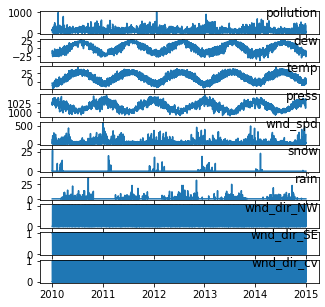

In [31]:
import numpy as np

# specify columns to plot
cols = dataset.columns

# plot each column
plt.figure(figsize = (5,5))
for i, col in enumerate(cols):
	plt.subplot(len(cols), 1, i+1)
	plt.plot(dataset[col])
	plt.title(dataset.columns[i], y=0.5, loc='right')

plt.show()

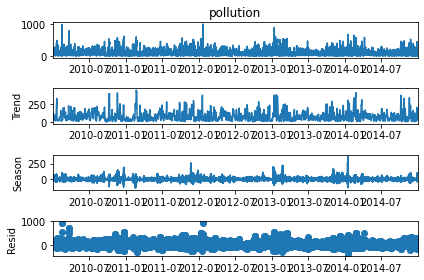

In [32]:
# seasonal decomposition
response_var = "pollution"

from statsmodels.tsa.seasonal import seasonal_decompose, STL

stl = STL(dataset[response_var], seasonal = 7, robust = True)
stl.fit().plot()
plt.show()

## Create train data

In [7]:
dataset.index = pd.date_range(start=dataset.index[0], 
                              end=dataset.index[-1], 
                              freq = 'H')


# take a subset of the full dataset
train_size = 10000
dataset_train = dataset.iloc[:train_size, :]



# ARIMA

## ARIMA exploratory analysis 


In [7]:
# tests for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(df):
    # ADF (H0: unit root is present)
    res_adf = adfuller(df)
    print(f"p-value ADF: {res_adf[1]}")
    
    # KPSS (H0: stationary)
    statistic, p_value, n_lags, critical_values = kpss(df, nlags="auto")
    print(f"p-value KPSS: {p_value}")

stationarity_tests(dataset[response_var])    


p-value ADF: 0.0
p-value KPSS: 0.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


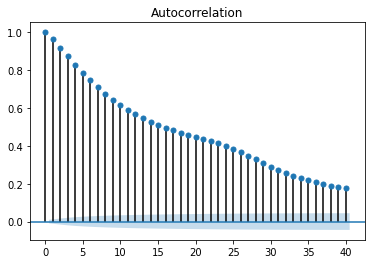

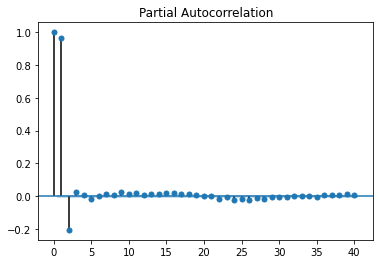

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(dataset[response_var], lags=40)
plot_pacf(dataset[response_var], lags=40)
plt.show()

## SARIMAX training

In [64]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [65]:
# defining exogeneous variables
exo_train = dataset_train.drop([response_var], axis = 1)

y_train, y_test, X_train, X_test = temporal_train_test_split(dataset_train[response_var], 
                                                             exo_train, 
                                                             test_size=500)

In [66]:
import itertools

# define parameters for grid search
p, d, q = range(2,3), [0], range(2,3)
P, D, Q, s = range(0,2), [0], range(0,2), [1]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
params_grid = list(itertools.product(pdq,seasonal_pdq))

In [67]:
import statsmodels.api as sm
import pandas as pd

def optim_pars_SARIMA(params_grid, exo_train = pd.DataFrame({})):
    '''
    For each parameter combination in 'params_grid', fit a SARIMA model. Compute and return AICs.
    Optionally can add exogeneous variables. 
    '''
    AIC = []
    for param in params_grid:
        order = param[0]
        seasonal_order = param[1]

        #train.index = pd.DatetimeIndex(train.index.values,
        #                               freq=train.index.inferred_freq)

        if exo_train.empty:
            sar = sm.tsa.statespace.SARIMAX(endog = y_train,
                                            order = order#,
                                            #seasonal_order = seasonal_order
                                            )
        else:
            sar = sm.tsa.statespace.SARIMAX(endog = y_train,
                                            exog = X_train,
                                            order = order#,
                                            #seasonal_order = seasonal_order
                                            )
        res = sar.fit(disp=False)
        AIC.append((param, res.aic, res))

    return AIC


In [68]:
# without exogeneous variables
ARIMA_results_AIC = optim_pars_SARIMA(params_grid)

ARIMA_results_AIC.sort(key = lambda x: x[1])

# optimal model according to AIC
print(f"\n Optimal model: parameters = {ARIMA_results_AIC[0]}")

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 Optimal model: parameters = (((2, 0, 2), (0, 0, 0, 1)), 88099.26939468898, <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f5e310b4d90>)


In [69]:
# with exogeneous variables
ARIMA_results_AIC_exo = optim_pars_SARIMA(params_grid, exo_train)

ARIMA_results_AIC_exo.sort(key = lambda x: x[1])

# optimal model according to AIC
print(f"\n Optimal model: parameters = {ARIMA_results_AIC_exo[0]}")

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



 Optimal model: parameters = (((2, 0, 2), (0, 0, 0, 1)), 88360.73692503785, <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f5e31086190>)


## SARIMAX residuals check

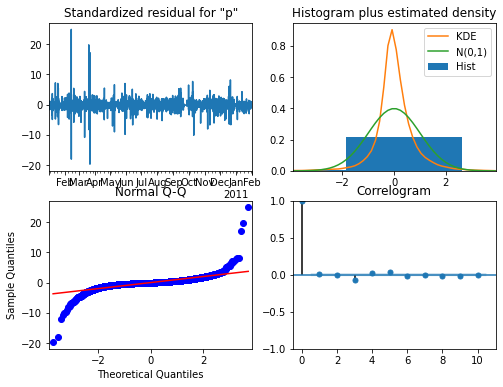

In [70]:
# residual check
res_opt = ARIMA_results_AIC[0][2]
res_opt.plot_diagnostics(figsize = (8,6))
plt.show()

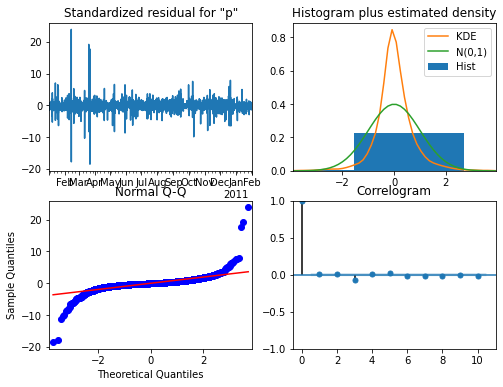

In [71]:
# residual check
res_opt_exo = ARIMA_results_AIC_exo[0][2]
res_opt_exo.plot_diagnostics(figsize = (8,6))
plt.show()

## SARIMAX forecasts

### Short horizon
The forecasting horizon is 1 time-step (day).
We do a one-day forecast 62 times.

In [72]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

In [73]:
# one-step forecasts
# We obtain these forecasts using a workaround: we define a model on full dataset but then make predictions 
# using the parameters from 'res_opt' model (sending 'res_opt.params' to the new model)


order = ARIMA_results_AIC[0][0][0]
seasonal_order = ARIMA_results_AIC[0][0][1]

mod = sm.tsa.statespace.SARIMAX(dataset_train[response_var], 
                                order = order)
res_roll = mod.filter(res_opt.params)
preds_arima_roll = res_roll.predict()
preds_arima_roll = preds_arima_roll[y_test.index]
preds_arima_roll

err_MAPE_short = MAPE(y_test, preds_arima_roll)

print(f"MAPE one-step forecasts: {err_MAPE_short}")

results_short_horizon = []
results_short_horizon.append(['SARIMAX', 
                               preds_arima_roll, 
                               MAPE(y_test, preds_arima_roll), 
                               np.sqrt(MSE(y_test, preds_arima_roll))])


MAPE one-step forecasts: 0.2115199545509073


### Medium horizon
The forecasting horizon is 7 time-steps (days). We use 54 different starting origins to produce 54 7-day forecasts.

In [74]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

from datetime import timedelta

# multi-step direct forecasts for 7 days (7 time-steps)

K = 7

err_MAPE, err_MSE = 0, 0
j = 1

for date in y_test.iloc[:-(K+1)].index:
    pred_test_multi = res_opt.get_prediction(start = date, end = date + timedelta(hours=K-1))
    err_MAPE += MAPE(pred_test_multi.predicted_mean, y_test[date:(date + timedelta(hours=K-1))])
    err_MSE += MSE(pred_test_multi.predicted_mean, y_test[date:(date + timedelta(hours=K-1))])
    j += 1

err_MAPE = err_MAPE / j
err_MSE = err_MSE / j
print(f"MAPE 7-day forecasts: {err_MAPE}")

# results medium horizon multistep direct
results_medium_horizon = []
results_medium_horizon.append(['SARIMAX-recursive', pred_test_multi.predicted_mean,
                                 err_MAPE, np.sqrt(err_MSE)])

MAPE 7-day forecasts: 1.940857707721662


### Long horizon


In [75]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

# multistep recursive forecasts
train_end = y_test.index[0]
test_end = y_test.index[-1]
pred_test = res_opt.get_prediction(start = train_end, end = test_end)

err_MAPE_long = MAPE(y_test, pred_test.predicted_mean)

print(f"MAPE long forecasts: {err_MAPE_long}")
# results_multistep_recursive = results_long_horizon
results_long_horizon = []
# results: [model_name, predictions, MAPE_error, MSE_error]
results_long_horizon.append(['SARIMAX', pred_test.predicted_mean, MAPE(y_test, pred_test.predicted_mean), 
                             np.sqrt(MSE(y_test, pred_test.predicted_mean))])
## one-step fixed to multistep recursive!!!


MAPE long forecasts: 0.8858742689430019


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


# LSTM and machine learning methods



## Conversion to supervised learning framework

To train LSTM, we convert the time series data to a supervised learning dataframe using a slicing window. 
In each supervised example, the features are the variable values at previous 'n_in' time steps and the response variable is pollution at the current time step. 


In [33]:
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, num_lags=1, num_predict_steps=1, dropnan=True):
    '''
    Transform a collection of time series into a dataframe suitable for supervised learning.
        data: a dataframe containing a number of time series
        num_lags: the number of lags to consider 
        n_out: the dimension of the output
        dropnan: True if drop NaN from final dataframe
    '''
  
    n_vars = data.shape[1]
    df = data.copy()

    cols, names = list(), list()
   
	  # input sequence (t-n, ... t-1)
    for i in range(num_lags, 0, -1):
        cols.append(df.shift(i))
        names += [f'{var_name}_t-{i}' for var_name in data.columns]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, num_predict_steps):
        cols.append(df.shift(-i))
        names += [f'{var_name}_t+{i}' for var_name in data.columns]

	  # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

	  # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [34]:
## scaling

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1, 2, 3, 4, 7))
scaler_response = MinMaxScaler(feature_range=(0,1)).fit(dataset_train[[response_var]])
data_normalized = scaler.fit_transform(dataset_train)
data_normalized = pd.DataFrame(data_normalized, columns = dataset_train.columns, index = dataset_train.index)

n_features = data_normalized.shape[1]
n_features

n_in = 7

In [35]:
# split into train and test

train_end_supervised = train_end

# using exogeneous variables
dataset_reduced = data_normalized 

# without exogeneous variables
dataset_reduced_uni = data_normalized[[response_var]]

train, test = dataset[:train_end_supervised][response_var], dataset[train_end_supervised:][response_var]
scaled_train, scaled_test = dataset_reduced[:train_end_supervised], dataset_reduced[train_end_supervised:]

scaled_train_uni, scaled_test_uni = dataset_reduced_uni[:train_end_supervised], dataset_reduced_uni[train_end_supervised:]


In [36]:
# MULTIVARIATE MODELING 
# -- prepare data to perform supervised learning

# reframing train and test separately

def reframe_data(scaled_train, scaled_test, num_lags, num_predict_steps):
    '''
    Reframe data using slicing window to use in a supervised learning framework. 
    '''
    #response_var = "kWh"

    reframed_train = series_to_supervised(scaled_train, num_lags = num_lags, num_predict_steps = num_predict_steps, dropnan=True)
    reframed_test = series_to_supervised(scaled_test, num_lags = num_lags, num_predict_steps = num_predict_steps, dropnan=True)

    # drop_vars = [f'{var_name}_t+0' for var_name in data.columns]
    drop_vars = []
    for i in range(num_predict_steps):
        drop_vars += [f'{var_name}_t+{i}' for var_name in scaled_train.columns if var_name != response_var]

    #drop_vars.remove(f'{response_name}_t+0')

    # drop columns we don't want to predict
    df_full_train = reframed_train.drop(drop_vars, axis = 1)
    df_full_test = reframed_test.drop(drop_vars, axis = 1)

    drop_responses = [f"{response_var}_t+{i}" for i in range(num_predict_steps)]

    X_test = df_full_test.drop(drop_responses, axis = 1)
    y_test_n = df_full_test[drop_responses]

    X_train = df_full_train.drop(drop_responses, axis = 1)
    y_train_n = df_full_train[drop_responses]

    return X_train, y_train_n, X_test, y_test_n


In [37]:
# reframe data into supervised learning framework
n_features = dataset_reduced.shape[1]
n_features_uni = dataset_reduced_uni.shape[1]
num_lags = 10
num_predict_steps = 1

print(f"n_features: {n_features}, num_lags: {num_lags}, num_predict_steps: {num_predict_steps}")

# for one-step forecasts
X_train, y_train_n, X_test, y_test_n = reframe_data(scaled_train, scaled_test, num_lags, num_predict_steps)

# for multi-step forecasts
X_train_uni, y_train_n, X_test_uni, y_test_n = reframe_data(scaled_train_uni, scaled_test_uni, num_lags, num_predict_steps)
                                                            
# for multi-step forecasts
X_train_uni_multi, y_train_n_multi, X_test_uni_multi, y_test_n_multi = reframe_data(scaled_train_uni, 
                                                                    scaled_test_uni, 
                                                                    num_lags, 
                                                                    num_predict_steps = 7)



n_features: 10, num_lags: 10, num_predict_steps: 1


## Random forest

In [38]:
def rescale(y_pred, index):
    '''
    Rescale predictions back to original scale.
    '''
    y_pred_rescaled = scaler_response.inverse_transform(y_pred.reshape(-1,1)).flatten()
    y_pred_rescaled = pd.Series(y_pred_rescaled, index = index)

    return y_pred_rescaled

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MAPE error: 0.22611215356706302


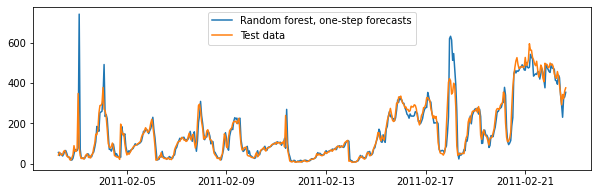

In [39]:
# train with exogeneous variables

import numpy as np
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train_n)
y_pred_rf = rf.predict(X_test)
y_pred_rf_rescaled = rescale(y_pred_rf, y_test_n.index) #pd.Series(y_pred_rf_rescaled[:,0], index = y_test_n.index)

y_test_rescaled = rescale(y_test_n.values, y_test_n.index)

plt.figure(figsize = (10,3))
plt.plot(y_pred_rf_rescaled, label = "Random forest, one-step forecasts")
plt.plot(y_test_rescaled, label = "Test data")
plt.legend()

err_MAPE_rf = MAPE(y_test_rescaled, y_pred_rf_rescaled) 

print(f"MAPE error: {err_MAPE_rf}")

In [ ]:
results_short_horizon.append(['Random forest', y_pred_rf_rescaled,
                               MAPE(y_test[num_lags:], y_pred_rf_rescaled),
                               np.sqrt(MSE(y_test[num_lags:], y_pred_rf_rescaled))])

## LSTM training


In [41]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [42]:
# reshape data to 3D-shape expected by LSTMs: [samples, timesteps, features]
import numpy as np

X_train_scaled_3d = np.array(X_train).reshape((X_train.shape[0], num_lags, n_features))
print(f"X_train_scaled_3d shape: {X_train_scaled_3d.shape}")

X_test_scaled_3d = np.array(X_test).reshape((X_test.shape[0], num_lags, n_features))
print(f"X_test_scaled_3d shape: {X_test_scaled_3d.shape}")

X_train_scaled_3d_uni = np.array(X_train_uni).reshape((X_train_uni.shape[0], num_lags, n_features_uni))
X_test_scaled_3d_uni = np.array(X_test_uni).reshape((X_test_uni.shape[0], num_lags, n_features_uni))

X_train_scaled_3d_uni_multi = np.array(X_train_uni_multi).reshape((X_train_uni_multi.shape[0], num_lags, n_features_uni))
X_test_scaled_3d_uni_multi = np.array(X_test_uni_multi).reshape((X_test_uni_multi.shape[0], num_lags, n_features_uni))

(9490, 10, 10)
(490, 10, 10)


In [43]:
def get_lstm_model(input, num_predict_steps):

    # network architecture
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, 
                        input_shape=(input[1], input[2])))
    model_lstm.add(LSTM(50, activation='relu'))
    model_lstm.add(Dense(num_predict_steps))
    model_lstm.compile(loss='mae', optimizer='adam')

    return model_lstm

Epoch 1/100
132/132 - 9s - loss: 0.0383 - val_loss: 0.0634 - 9s/epoch - 66ms/step
Epoch 2/100
132/132 - 5s - loss: 0.0314 - val_loss: 0.0536 - 5s/epoch - 36ms/step
Epoch 3/100
132/132 - 5s - loss: 0.0265 - val_loss: 0.0444 - 5s/epoch - 36ms/step
Epoch 4/100
132/132 - 5s - loss: 0.0228 - val_loss: 0.0375 - 5s/epoch - 36ms/step
Epoch 5/100
132/132 - 5s - loss: 0.0199 - val_loss: 0.0283 - 5s/epoch - 42ms/step
Epoch 6/100
132/132 - 5s - loss: 0.0176 - val_loss: 0.0258 - 5s/epoch - 38ms/step
Epoch 7/100
132/132 - 5s - loss: 0.0155 - val_loss: 0.0240 - 5s/epoch - 36ms/step
Epoch 8/100
132/132 - 5s - loss: 0.0151 - val_loss: 0.0224 - 5s/epoch - 36ms/step
Epoch 9/100
132/132 - 5s - loss: 0.0143 - val_loss: 0.0214 - 5s/epoch - 36ms/step
Epoch 10/100
132/132 - 5s - loss: 0.0136 - val_loss: 0.0207 - 5s/epoch - 36ms/step
Epoch 11/100
132/132 - 5s - loss: 0.0135 - val_loss: 0.0206 - 5s/epoch - 37ms/step
Epoch 12/100
132/132 - 5s - loss: 0.0133 - val_loss: 0.0207 - 5s/epoch - 37ms/step
Epoch 13/100


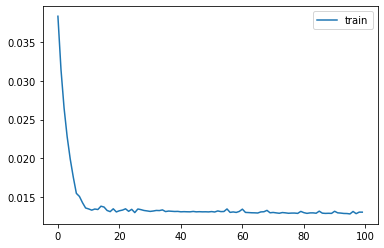

In [44]:
# model with no exogeneous variables
model_lstm = get_lstm_model(X_train_scaled_3d_uni.shape,  num_predict_steps = 1)

# model with exogeneous variables
model_lstm_exo = get_lstm_model(X_train_scaled_3d.shape,  num_predict_steps = 1)

# training without exogeneous variables
history_uni = model_lstm.fit(X_train_scaled_3d_uni, y_train_n, 
                    epochs=100, 
                    batch_size=72, 
                    validation_data=(X_test_scaled_3d_uni, y_test_n), 
                    verbose=2, 
                    shuffle=False)
# plot history
plt.plot(history_uni.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


Epoch 1/100
132/132 - 8s - loss: 0.0475 - 8s/epoch - 60ms/step
Epoch 2/100
132/132 - 5s - loss: 0.0366 - 5s/epoch - 37ms/step
Epoch 3/100
132/132 - 5s - loss: 0.0330 - 5s/epoch - 36ms/step
Epoch 4/100
132/132 - 5s - loss: 0.0306 - 5s/epoch - 37ms/step
Epoch 5/100
132/132 - 5s - loss: 0.0290 - 5s/epoch - 36ms/step
Epoch 6/100
132/132 - 5s - loss: 0.0275 - 5s/epoch - 37ms/step
Epoch 7/100
132/132 - 5s - loss: 0.0259 - 5s/epoch - 37ms/step
Epoch 8/100
132/132 - 5s - loss: 0.0238 - 5s/epoch - 37ms/step
Epoch 9/100
132/132 - 5s - loss: 0.0221 - 5s/epoch - 36ms/step
Epoch 10/100
132/132 - 5s - loss: 0.0206 - 5s/epoch - 37ms/step
Epoch 11/100
132/132 - 5s - loss: 0.0190 - 5s/epoch - 36ms/step
Epoch 12/100
132/132 - 5s - loss: 0.0179 - 5s/epoch - 37ms/step
Epoch 13/100
132/132 - 5s - loss: 0.0167 - 5s/epoch - 37ms/step
Epoch 14/100
132/132 - 5s - loss: 0.0156 - 5s/epoch - 37ms/step
Epoch 15/100
132/132 - 5s - loss: 0.0152 - 5s/epoch - 37ms/step
Epoch 16/100
132/132 - 5s - loss: 0.0151 - 5s/epo

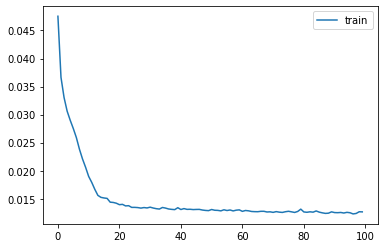

In [45]:
# training with exogeneous variables
history = model_lstm_exo.fit(X_train_scaled_3d, y_train_n, 
                    epochs=100, 
                    batch_size=72, 
                    #validation_data=(X_test_scaled_3d, y_test_n), 
                    verbose=2, 
                    shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Epoch 1/100
132/132 - 8s - loss: 0.0485 - 8s/epoch - 64ms/step
Epoch 2/100
132/132 - 5s - loss: 0.0427 - 5s/epoch - 37ms/step
Epoch 3/100
132/132 - 5s - loss: 0.0405 - 5s/epoch - 36ms/step
Epoch 4/100
132/132 - 7s - loss: 0.0386 - 7s/epoch - 53ms/step
Epoch 5/100
132/132 - 5s - loss: 0.0369 - 5s/epoch - 37ms/step
Epoch 6/100
132/132 - 5s - loss: 0.0357 - 5s/epoch - 38ms/step
Epoch 7/100
132/132 - 5s - loss: 0.0347 - 5s/epoch - 37ms/step
Epoch 8/100
132/132 - 5s - loss: 0.0335 - 5s/epoch - 37ms/step
Epoch 9/100
132/132 - 5s - loss: 0.0328 - 5s/epoch - 37ms/step
Epoch 10/100
132/132 - 5s - loss: 0.0318 - 5s/epoch - 37ms/step
Epoch 11/100
132/132 - 5s - loss: 0.0311 - 5s/epoch - 36ms/step
Epoch 12/100
132/132 - 5s - loss: 0.0306 - 5s/epoch - 37ms/step
Epoch 13/100
132/132 - 5s - loss: 0.0303 - 5s/epoch - 36ms/step
Epoch 14/100
132/132 - 5s - loss: 0.0301 - 5s/epoch - 36ms/step
Epoch 15/100
132/132 - 5s - loss: 0.0299 - 5s/epoch - 36ms/step
Epoch 16/100
132/132 - 5s - loss: 0.0299 - 5s/epo

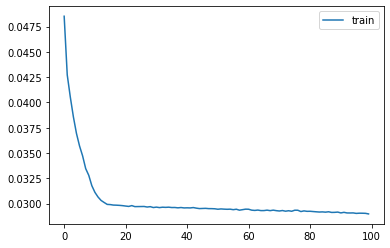

In [46]:
# model for 7-day forecasts (with no exogeneous variables)
model_lstm_uni_multistep = get_lstm_model(X_train_scaled_3d_uni_multi.shape, num_predict_steps = 7)

# training without exogeneous variables
history_uni_multistep = model_lstm_uni_multistep.fit(X_train_scaled_3d_uni_multi, y_train_n_multi, 
                    epochs=100, 
                    batch_size=72, 
                    #validation_data=(X_test_scaled_3d, y_test_n), 
                    verbose=2, 
                    shuffle=False)
# plot history
plt.plot(history_uni_multistep.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## LSTM forecasts

### Short horizon

In [49]:
def get_lstm_predictions(model_lstm, test_data):
    '''
    Return model predictions on test_data, rescaled to original scale.
    '''
    preds_lstm = model_lstm.predict(test_data).flatten()
    # rescale predictions to original scale
    preds_lstm_rescaled = rescale(preds_lstm, index = y_test_n.index)

    return preds_lstm_rescaled

# rescale y_test to original scale (for latter plotting)
y_test_rescaled = rescale(np.array(y_test_n), index = y_test_n.index)

# compute onestep moving origin predictions, with exogeneous variables
preds_lstm_rescaled = get_lstm_predictions(model_lstm_exo, X_test_scaled_3d)
results_short_horizon.append(['LSTM exo', preds_lstm_rescaled,
                              MAPE(y_test_rescaled, preds_lstm_rescaled),
                              np.sqrt(MSE(y_test_rescaled, preds_lstm_rescaled))])

# compute onestep moving origin predictions, no exogeneous variables
preds_lstm_rescaled = get_lstm_predictions(model_lstm, X_test_scaled_3d_uni)
results_short_horizon.append(['LSTM', preds_lstm_rescaled,
                              MAPE(y_test_rescaled, preds_lstm_rescaled),
                              np.sqrt(MSE(y_test_rescaled, preds_lstm_rescaled))])



### Medium horizon

In [54]:
def rescale_matrix(y_pred, index):
    '''
    Rescale predictions back to original scale.
    '''
    y_pred_rescaled = pd.DataFrame({})
    
    for col in y_pred:    
        col_scaled = scaler_response.inverse_transform(col.reshape(-1,1))        
        y_pred_rescaled = pd.concat([y_pred_rescaled, pd.Series(col_scaled.flatten())], axis = 1)
    
    y_pred_rescaled = y_pred_rescaled.T
    y_pred_rescaled.index = index 
    return y_pred_rescaled#pd.DataFrame(y_pred_rescaled, index = index)

In [55]:
def get_lstm_predictions_multistep(model_lstm, test_data, y_test_n):
    '''
    Return model predictions on test_data, rescaled to original scale.
    '''
    preds_lstm = model_lstm.predict(test_data)
    # rescale predictions to original scale
    preds_lstm_rescaled = rescale_matrix(preds_lstm, index = y_test_n.index)

    return preds_lstm_rescaled

def get_lstm_predictions(model_lstm, test_data, y_test_n):
    '''
    Return model predictions on test_data, rescaled to original scale.
    '''
    preds_lstm = model_lstm.predict(test_data).flatten()
    # rescale predictions to original scale
    preds_lstm_rescaled = rescale(preds_lstm, index = y_test_n.index)

    return preds_lstm_rescaled

# rescale y_test to original scale (for latter plotting)
y_test_rescaled = rescale_matrix(np.array(y_test_n_multi), index = y_test_n_multi.index)

# compute onestep moving origin predictions, with exogeneous variables
preds_lstm_rescaled_multi = get_lstm_predictions_multistep(model_lstm_uni_multistep, X_test_scaled_3d_uni_multi, y_test_n_multi)
preds_lstm_rescaled_multi.shape

(484, 7)

In [56]:
results_medium_horizon.append(['LSTM-direct', preds_lstm_rescaled_multi,
                              MAPE(y_test_rescaled, preds_lstm_rescaled_multi),
                              np.sqrt(MSE(y_test_rescaled, preds_lstm_rescaled_multi))])


### Long horizon

In [58]:
# compute one-step fixed origin predictions, no exogeneous variables
import datetime

def multistep_recursive(model):
    '''
    Create multistep_recursive predictions for lstm model. 
    Only implemented for univariate case (i.e. no exgoenegous variables).
    '''
    preds = []
    X0 = X_test_uni.iloc[0]
    date = X_test_uni.index[0]

    dates = []
    
    X0_3d = np.array(X0).reshape((1, num_lags, n_features_uni))
    X0_3d_update = X0_3d

    for i in range(X_test.shape[0]):
        preds_lstm_one = model.predict(X0_3d_update).flatten()

        # update with new onestep forecast
        X0_3d_update = np.append(X0_3d_update[0][1:], preds_lstm_one)
        X0_3d_update = np.array(X0_3d_update).reshape((1, num_lags, n_features_uni))
        preds.append(preds_lstm_one[0])
        date += datetime.timedelta(hours=1)
        dates.append(date)

    return pd.Series(preds, index = dates)

y_test_rescaled = rescale(np.array(y_test_n), index = y_test_n.index)
preds_multistep_recursive = multistep_recursive(model_lstm)
preds_multistep_recursive = rescale(preds_multistep_recursive.values, preds_multistep_recursive.index)


In [59]:
results_long_horizon.append(['LSTM', preds_multistep_recursive, 
                              MAPE(y_test_rescaled, preds_multistep_recursive),
                              MSE(y_test_rescaled, preds_multistep_recursive)])

# Final comparison

## Short horizon (1-day forecasts)

Short horizon: One-step forecasts


,MAPE
Model Name,
LSTM exo,0.200541
LSTM,0.190325
SARIMAX,0.211520


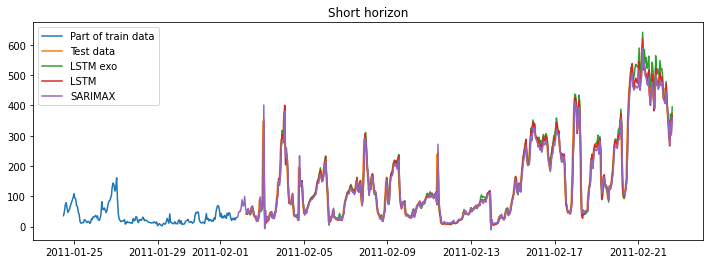

In [76]:
# plots
print("Short horizon: One-step forecasts")
names, MAPEs = [], []

plt.figure(figsize = (12, 4))
plt.title("Short horizon")
plt.plot(train[-200:], label = "Part of train data")
plt.plot(y_test_rescaled, label = "Test data")

for item in results_short_horizon:
    names.append(item[0])
    MAPEs.append(item[2])
    plt.plot(item[1], label = item[0])

plt.legend(loc = "upper left")

comparison_short = pd.DataFrame({'Model Name': names, 'MAPE': MAPEs})
comparison_short = comparison_moving.set_index('Model Name')
comparison_short

## Medium horizon (7-day forecasts): LSTM (direct forecast) and SARIMAX (recursive forecast)

In [77]:
print("Medium horizon forecasts")

names, MAPEs = [], []

for item in results_medium_horizon:
    names.append(item[0])
    MAPEs.append(item[2])


comparison_medium = pd.DataFrame({'Model Name': names, 'MAPE': MAPEs})
comparison_medium = comparison_fixed.set_index('Model Name')
comparison_medium

Medium horizon forecasts


,MAPE
Model Name,
LSTM-direct,0.579080
SARIMAX-recursive,1.940858


## Long horizon: recursive forecasts

Long horizon recursive forecasts


,MAPE
Model Name,
LSTM,7.299329
SARIMAX,0.885874


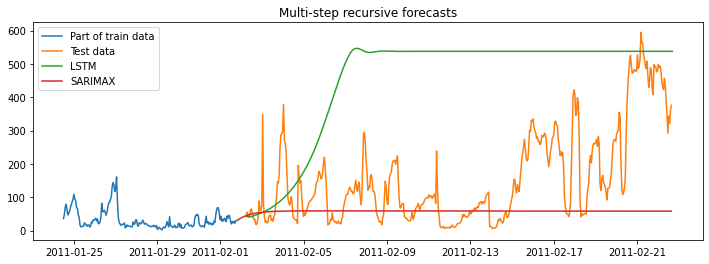

In [78]:
print("Long horizon recursive forecasts")

names, MAPEs = [], []

plt.figure(figsize = (12, 4))
plt.title("Multi-step recursive forecasts")
plt.plot(train[-200:], label = "Part of train data")
plt.plot(y_test_rescaled, label = "Test data")

for item in results_long_horizon:
    names.append(item[0])
    MAPEs.append(item[2])
    plt.plot(item[1], label = item[0])

plt.legend(loc = "upper left")

comparison_long = pd.DataFrame({'Model Name': names, 'MAPE': MAPEs})
comparison_long = comparison_fixed.set_index('Model Name')
comparison_long